# This script is used for general purpose data handling with Delft3D data source

In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import cuda
import pandas as pd
import plotly
import plotly.graph_objects as go
import time
from matplotlib.cm import get_cmap
from scipy.spatial.distance import cdist
from WGS import WGS
import os
from datetime import datetime
import concurrent.futures
from shapely.geometry import Polygon, Point
from tqdm import tqdm
from joblib import Parallel, delayed
from matplotlib.gridspec import GridSpec
import pickle
from skgstat import Variogram
from scipy.interpolate import interp2d
import fast_interp
# from fast_interp import interp2d
import netCDF4

def vectorize(v):
    return np.array(v).reshape(-1, 1)

# s1: load operation area
plg_op = pd.read_csv("OP2/OPA_GOOGLE.csv").to_numpy()
plg_op_shapely = Polygon(plg_op)
def is_point_legal(lat, lon):
    point = Point(lat, lon)
    return plg_op_shapely.contains(point)


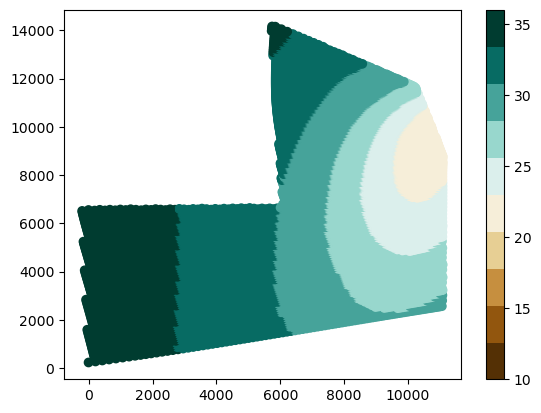

In [4]:
with open('oct_prior.pickle', 'rb') as handle:
    oct_prior = pickle.load(handle)

lat_d = oct_prior['lat']
lon_d = oct_prior['lon']

wind_dir = "North"
wind_level = "Moderate"
sal_d = np.mean(oct_prior[wind_dir][wind_level], axis=0)

lato = 41.04068871469593 
lono = -8.813846858228182
wg = WGS()
wg.set_origin(lato, lono)

xd, yd = wg.latlon2xy(lat_d, lon_d)
plt.scatter(yd, xd, c=sal_d, cmap=get_cmap("BrBG", 10), vmin=10, vmax=36)
plt.colorbar()


# t1 = time.time()
# for i in range(salinity.shape[0]):
#     S_sample = salinity[i, :, :, 0].reshape(-1, 1) # sample each frame
#     residual = S_sample - S_f
#     range_coef.append(V_v.cof[0])
#     sill_coef.append(V_v.cof[1])
#     nugget_coef.append(V_v.cof[2])

[2.99999989e+03 6.47980109e+00 4.68589604e-12]


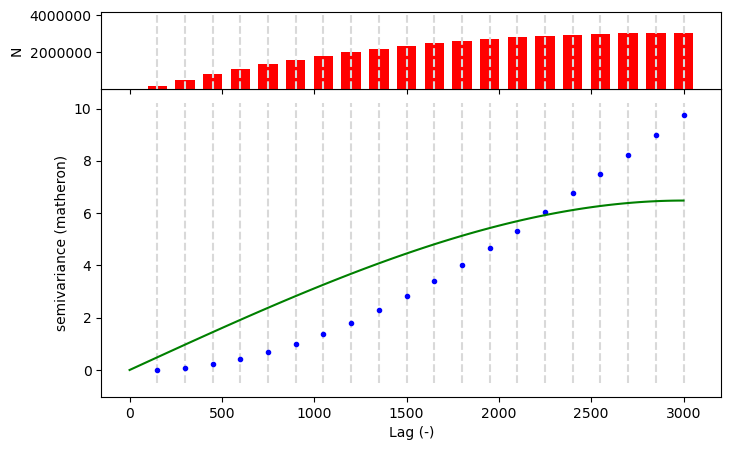

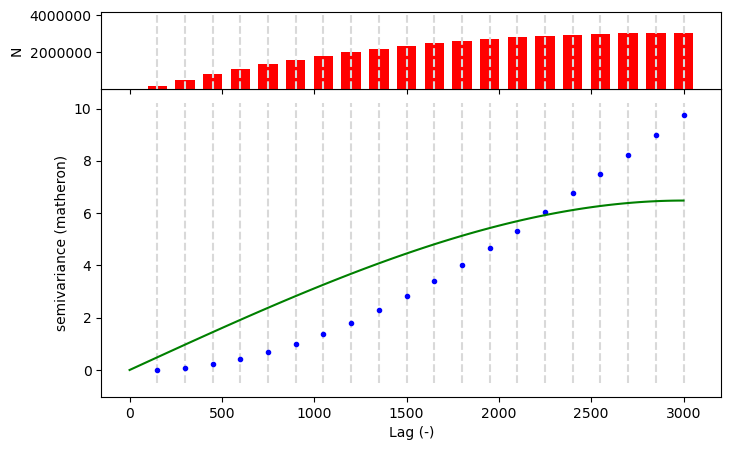

In [3]:
residual = sal_d - np.mean(sal_d)
V_v = Variogram(coordinates = np.stack((xd, yd), axis=1), values = residual, n_lags = 20, maxlag = 3000, use_nugget=True)
print(V_v.cof)
V_v.plot()

# In-situ measurements variogram analysis

/tmp/ipykernel_324790/3865505299.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = np.array(data['lat'])
/tmp/ipykernel_324790/3865505299.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = np.array(data['lon'])
/tmp/ipykernel_324790/3865505299.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silenc

array([-7.3558865, -7.3467083, -7.402151 , ...,  0.6354866,  0.6400337,
        0.6394043], dtype=float32)

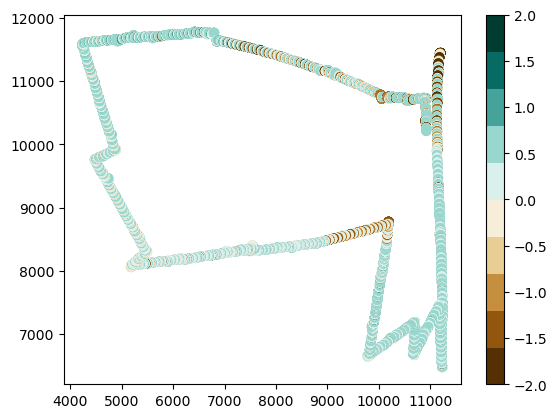

In [34]:
filepath = "in-situ/"
files = os.listdir(filepath)
file = filepath + files[0]
data = netCDF4.Dataset(file)
lat = np.array(data['lat'])
lon = np.array(data['lon'])
sal = np.array(data['sal'])
x, y = WGS.latlon2xy(lat, lon)
from skgstat import Variogram
residual = sal - np.nanmean(sal)
plt.scatter(y, x, c=residual, cmap=get_cmap("BrBG", 10), vmin=-2, vmax=2)
plt.colorbar()
residual

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   6865.92
Sill:              0.75
Nugget:            0.85
        


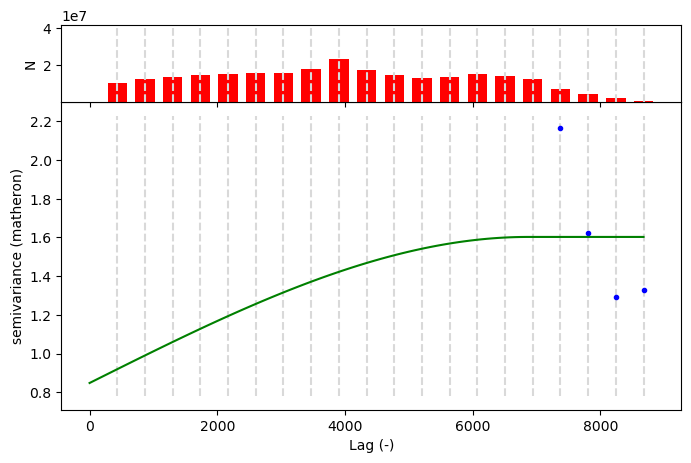

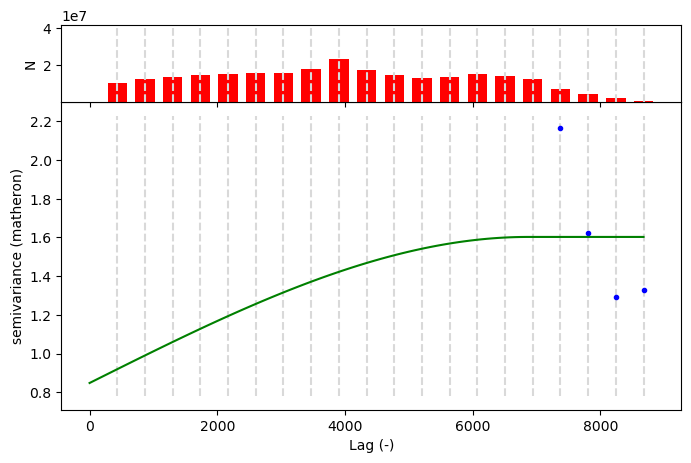

In [42]:
coords = np.stack((x, y), axis=1)
V = Variogram(coordinates = coords, values = residual, n_lags=20, maxlag=20000, use_nugget=True)
print(V)
V.plot()